# Предобработка данных и функции потерь в линейной регрессии

## Данные
Для демонстраций загрузим набор данных [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/Automobile). В данных присутствуют категориальные, целочисленные и вещественнозначные признаки.

In [2]:
import pandas as pd
X_raw = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data", \
                    header=None, na_values=["?"])

In [3]:
X_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [4]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

## Предобработка данных
Предобработка данных важна при применении любых методов машинного обучения, а в особенности для линейных моделей. В sklearn предобработку удобно делать с помощью модуля [preprocessing](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) или методов библиотеки pandas.

In [8]:
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

### Заполнение пропусков
В матрице объекты-признаки могут быть пропущенные значения, и это вызовет исключение при попытке передать такую матрицу в функцию обучения модели или даже предобработки. Если пропусков немного, можно удалить объекты с пропусками из обучающей выборки. Заполнить пропуски можно разными способами:
* заполнить средними (mean, median);
* предсказывать пропущенные значения по непропущенным.

Последний вариант сложный и применяется редко. Для заполнения константами можно использовать метод датафрейма fillna, для замены средними - класс preprocessing.Imputer.

In [6]:
# для удобства работы с нашим датасетом создаем маску, указывающую на столбцы с категориальными признаками
cat_features_mask = (X_raw.dtypes == "object").values # категориальные признаки имеют тип "object"

In [9]:
# для вещественнозначных признаков заполним пропуски средними
X_real = X_raw[X_raw.columns[~cat_features_mask]]
mis_replacer = SimpleImputer(strategy="mean")
X_no_mis_real = pd.DataFrame(data=mis_replacer.fit_transform(X_real), columns=X_real.columns)
# для категориальных - пустыми строками
X_cat = X_raw[X_raw.columns[cat_features_mask]].fillna("")
X_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1)

In [10]:
X_no_mis.head()

,0,1,9,10,11,12,13,16,18,19,...,2,3,4,5,6,7,8,14,15,17
0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,...,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,...,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,...,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi


Всегда нужно осознавать, случайны ли пропуски в каком-то признаке. Иногда факт отсутствия информации о значении признака может сам быть важным признаком, который необходимо добавить к другим признакам.

__Пример:__ предсказание возраста пользователя по данным с его телефона. Поскольку люди старшего возраста чаще пользуются простыми телефонами, факт отсутствия каких-то данных (например, истории посещенных интернет-страниц), скорее всего, будет хорошим признаком.

Для категориальных признаков рекомендуется создавать отдельную категорию, соответствующую пропущенному значению. В наши данных пропусков в категориальных признаках нет.

### Преобразование нечисловых признаков
Практически все методы машинного обучения требуют, чтобы на вход функции обучения подавалась вещественная матрица. В процессе обучения используются свойства вещественных чисел, в частности, возможность сравнения и применения арифметических операций. Поэтому, даже если формально в матрице объекты-признаки записаны числовые значения, нужно всегда анализировать, можно ли относиться к ним как к числам. 

__Пример:__ некоторые признаки могут задаваться целочисленными хешами или id (например, id пользователя соц. сети), однако нельзя сложить двух пользователей и получить третьего, исходя из их id (как это может сделать линейная модель).

Это пример категориального признака, принимающего значения из неупорядоченного конечного множества $K$. К таким признакам обычно применяют [one-hot encoding](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) (вместо одного признака создают $K$ бинарных признаков - по одному на каждое возможное значение исходного признака). В sklearn это можно сделать с помощью классов LabelEncoder + OneHotEncoding, но проще использовать функцию pd.get_dummies.

Следует заметить, что в новой матрице будет очень много нулевых значений. Чтобы не хранить их в памяти, можно задать параметр OneHotEncoder(sparse = True) или .get_dummies(sparse=True), и метод вернет [разреженную матрицу](http://docs.scipy.org/doc/scipy/reference/sparse.html), в которой хранятся только ненулевые значения. Выполнение некоторых операций с такой матрицей может быть неэффективным, однако большинство методов sklearn умеют работать с разреженными матрицами.

__Вопрос:__ какая проблема возникнет при применении такого способа кодирования для обучения линейной регрессии?
    
Необходимо удалить один из столбцов, созданных для каждого признака. Для этого в get_dummies надо поставить drop_first=True.

In [11]:
X_no_mis.shape

(205, 25)

In [12]:
X_dum = pd.get_dummies(X_no_mis, drop_first=True)
print(X_dum.shape)
X_dum.head()

(205, 66)


,0,1,9,10,11,12,13,16,18,19,...,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,0,0,0,0,0,0,0,1,0,0
1,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,0,0,0,0,0,0,0,1,0,0
2,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,...,0,0,0,0,0,0,0,1,0,0
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,...,0,0,0,0,0,0,0,1,0,0
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,...,0,0,0,0,0,0,0,1,0,0


Помимо категориальных, преобразования требуют, например, строковые признаки. Их можно превращать в матрицу частот слов [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer), матрицу частот буквосочетаний фиксированной длины, можно извлекать другие признаки (например, длина строки).

### Масштабирование признаков
При начале работы с данными всегда рекомендуется приводить все признаки к одному масштабу.  Это важно по нескольким причинам:
* ускорение обучения модели (пояснение на лекции);
* улучшение численной устойчивости при работе с матрицей объекты-признаки (рядом с нулем чисел с плавающей точкой больше, чем с области больших чисел)
* для линейных моделей: интерпретация весов при признаках как меры их значимости.

Первый популярный способ масштабирования - нормализация: вычитание среднего из каждого признака и деление на стандартное отклонение (StandardScaler в sklearn). Второй популярный способ: вычитание минимума из каждого признака, а затем деление на разницу максимального и минимального значения (MinMaxScaler в sklearn).

In [13]:
normalizer = preprocessing.MinMaxScaler()
X_real_norm_np = normalizer.fit_transform(X_dum)
X = pd.DataFrame(data=X_real_norm_np)

In [14]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,1.0,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.6,0.298429,0.230321,0.449254,0.433333,0.383333,0.517843,0.343396,0.100000,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.8,0.518325,0.384840,0.529851,0.491667,0.541667,0.329325,0.181132,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.8,0.518325,0.373178,0.529851,0.508333,0.541667,0.518231,0.283019,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Добавление признаков
Особенно важным моментом для линейной регрессии является нелинейное преобразование признаков. Это позволяет использовать линейную регрессию для моделирования нелинейных зависимостей. Наиболее популярны следующие преобразования: полиномиальные признаки (PolynomialFeatures в sklearn), взятие логарифма, квадратного корня, применение тригонометрических функий.

Например, в нашем датасете зависимость целевой перемнной от шестого признака скорее квадратичная, чем линейная:

In [15]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

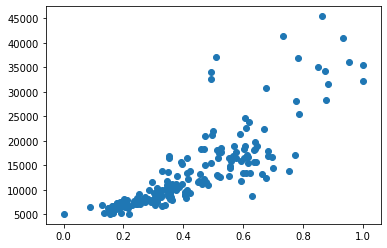

In [16]:
plt.scatter(X[6], y)

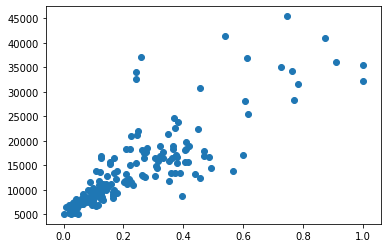

In [17]:
plt.scatter(X[6]**2, y)

А для признака номер 13 линеаризовать зависимость получается с помощью функции $\frac 1 {\sqrt{\cdot}}$

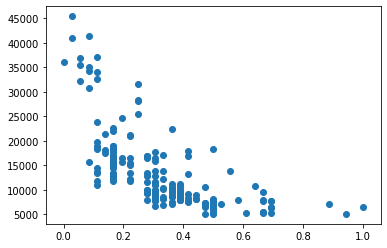

In [18]:
plt.scatter(X[13], y)

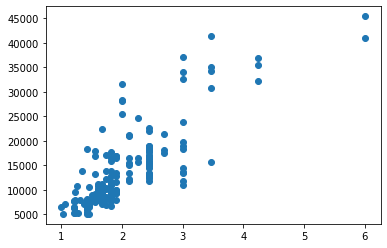

In [19]:
plt.scatter(1./np.sqrt(X[13]), y)

Обратите внимание, что при генерации полиномиальных признаков матрица объекты-признаки может занимать очень много памяти. Генерация полиномиальных признаков нужна, например, в случае, если вы хотите с помощью линейной регрессии настраивать полиномиальную модель зависимости целевого признака от данных.

## Функции потерь в регрессии

Функционал качества в задачах обучения с учителем обычно задается в виде суммы по объектам выборки:
$$Q(a) = \frac 1 \ell \sum_{i=1}^\ell L(y_i, a(x_i)),$$
где $L(\cdot, \cdot)$ - функция потерь, задающая штраф за разницу между предсказанием и истинным значением целевого признака. Свойства функции потерь:
* $L(y_i, a(x_i)) \geqslant 0$;
* $L(y_i, y_i) = 0$. 

Как отмечалось на первой лекции, функционал качества должен в первую очередь отвечать требованиям задачи, при этом математические свойства функции потерь могут быть неудобны для оптимизации. 

__Пример:__ если мы не различаем маленькие ошибки (между 0.01 и 0.1 нет особой разницы), но зато не хотим получать большие ошибки, можно использовать следующую функцию потерь:

$$L(y_i, a(x_i)) = [| y_i - a(x_i) | < \varepsilon],$$ $\varepsilon$ - допустимая разница между предсказанием и фактом.


### Среднеквадратичная и средняя абсолютная ошибка
Кроме требований заказчика, функционал качества должен учитывать математические особенности модели, например устойчивость к шумовым объектам. В линейной регрессии Mean Squared Error: $L(y_i, a(x_i)) = (a(x_i) - y_i)^2$ не обладает этим свойством, потому что задает очень большие штрафы за большие отклонения от фактического значения. 

Рассмотрим это явление на примере. Выберем один признак, от которого целевой признак (имеющий индекс 15 в матрице X) зависит практически линейно. Добавим к выборке два объекта-выброса и посмотрим, как изменится оптимизированная на MSE прямая.

In [20]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression as LR

In [21]:
X_subset = X[[7, 15]].values
X_subset_modified = np.vstack((X_subset, [[1, 90], [2, 50]])) # добавление двух шумовых точек

In [22]:
def scatter_points_and_plot_line_MSE(X_subset):
    plt.scatter(X_subset[:, 0], X_subset[:, 1])   # визуализируем точки
    lr = LR()
    lr.fit(X_subset[:, 0][:, np.newaxis], X_subset[:, 1])  # найдем веса линейной модели
    grid = np.linspace(0, 2, 100)
    line = lr.predict(grid[:, np.newaxis])
    plt.plot(grid, line)   # визуализируем прямую

Text(0.5, 0, 'x')

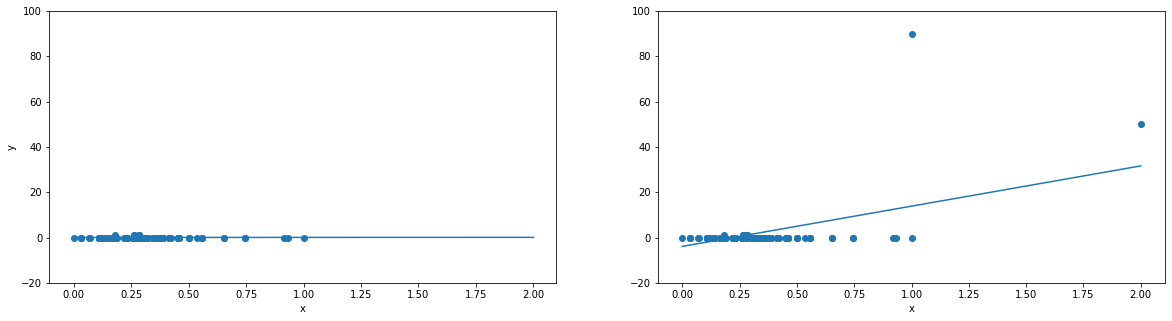

In [23]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
scatter_points_and_plot_line_MSE(X_subset)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
scatter_points_and_plot_line_MSE(X_subset_modified)
plt.ylim(-20, 100)
plt.xlabel("x")

Из-за шумовых объектов прямая достаточно сильно изменила наклон. Поэтому вместо MSE часто используют Mean Absoulte Error: $L(y_i, a(x_i)) = |a(x_i) - y_i|$:

Теперь обучим регрессию, оптимизируя MAE. В sklearn такая регрессия не реализована, но можно использовать модуль statsmodels

In [24]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [25]:
def scatter_points_and_plot_line_MAE(X_subset):
    mod = smf.quantreg('f15 ~ f7', pd.DataFrame(data=X_subset, columns=["f7", "f15"])) # задаеем зависимость и передаем данные
    res = mod.fit(q=0.5)
    plt.scatter(X_subset[:, 0], X_subset[:, 1])   # визуализируем точки
    grid = np.linspace(0, 2, 100)
    plt.plot(grid, grid * res.params["f7"] + res.params["Intercept"])   # визуализируем прямую
    return mod, res

/usr/local/Cellar/python/3.7.1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:205: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/usr/local/Cellar/python/3.7.1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:207: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/usr/local/Cellar/python/3.7.1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:218: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0


Text(0.5, 0, 'x')

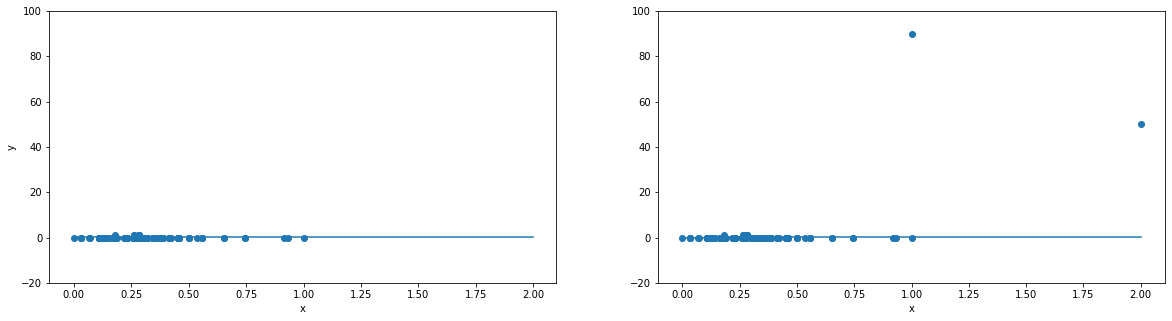

In [26]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model, result = scatter_points_and_plot_line_MAE(X_subset)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
model, result = scatter_points_and_plot_line_MAE(X_subset_modified)
plt.ylim(-20, 100)
plt.xlabel("x")

Прямая не изменила направление из-за выбросов.

Попробуем добавить больше шумовых объектов:

In [28]:
X_subset_modified_twice = np.vstack((X_subset_modified, np.random.randint(5, size=60).reshape(-1, 2)*[1, 30])) # добавление двух шумовых точек

Text(0.5, 0, 'x')

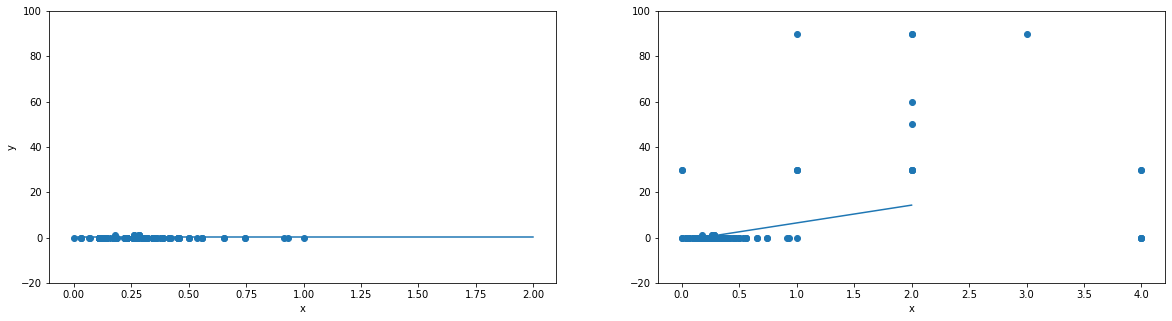

In [29]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model, result = scatter_points_and_plot_line_MAE(X_subset)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
model, result = scatter_points_and_plot_line_MAE(X_subset_modified_twice)
plt.ylim(-20, 100)
plt.xlabel("x")

Прямая изменила наклон, когда мы добавили 30 (почти 15%) шумовых точек.

Рассмотрим некоторые свойства MSE и MAE.

Пусть алгоритм возвращает константный ответ: $a(x) = C$. Такие алгоритмы используются, когда нужно по истории значений целевого признака предсказать его новое значение (например, сумму покупок в супермаркете).

__Задача.__ Найдите $C$, минимизирующий среднеквадратичную ошибку.


__Задача.__ Найдите $C$, минимизирующий среднюю абсолютную ошибку.

_Решение._ $$MAE(C) =  \sum_{i=1}^\ell |C - y_i|$$

Покажем, что минимум MAE достигается при $C = median(y_1, \dots, y_\ell) = m.$ Рассмотрим $C < m$.

$$|y_i - C| - |y_i - m| = \begin{cases} C - m, y_i < С  \\ -C - m + 2 y_i, C \leqslant y_i \leqslant m \\ - (C - m), y_i > m \end{cases}$$
$$|y_i - C| - |y_i - m| \geqslant - (C - m) + 2(C - m) [y_i \leqslant m]$$
Суммируем по i:
$$\ell MAE(C) - \ell MAE(m) \geqslant - \ell (C - m) + 2 (C - m) \sum_{i=1}^\ell [y_i \leqslant m]$$

Так как m - медиана, $\sum_{i=1}^\ell [y_i \leqslant m] \geqslant \frac \ell 2$. Тогда

$$\ell MAE(C) - \ell MAE(m) \geqslant - \ell (C - m) + 2 (C - m) \frac \ell 2 = 0.$$

Итак, для $C < m$ $MAE(C) \geqslant MAE(m)$. Аналогично показывается, что при для $C > m$ $MAE(C) \geqslant MAE(m)$.

Поскольку средняя абсолютная ошибка не является дифференцируемой по $w$ функцией, оптимизировать ее напрямую методом градиентного спуска не удастся. Для этого используются субградиентные или другие методы.

### Huber Loss
Иногда используют "гибрид" MAE и MSE, который, как и MAE, устойчив к шумовым объектам, и как и MSE, мало штрафует малые отклонения от фактического значени целевого признака - Huber Loss:
$$L(y_i, a(x_i)) = \phi_\varepsilon(a(x_i) - y_i)$$
$$\phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}$$

Легко проверить, что у этой функции существует непрерывная первая проиводная во всех точках.

Оптимизация Huber Loss реализована в sklearn:

In [30]:
from sklearn.linear_model import HuberRegressor

### Quantile Loss

В некоторых задачах штраф за ошибку зависит не только от величины абсолютного отклонения от фактического значения, но и от знака этого отклонения. Например, лучше предсказать спрос больше, чем будет по факту, чем меньше, потому что во втором случае будет потеряна прибыль. В этом случае используется квантильная регрессия со следующей функцией потерь:
$$L(y_i, a(x_i)) = \rho_\tau(y_i - x_i^T w),$$
$$\rho_\tau(z) = \begin{cases} \tau z, \quad z > 0, \\ (\tau - 1) z, \quad z \leqslant 0 \end{cases}$$
Параметр $\tau$ влияет на то, насколько различаются штрафы за положительную и отрицательную разницу.

Изобразим график квантильной функции потерь вместе с другими рассмотренными:

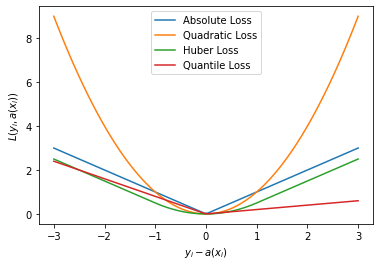

In [32]:
grid = np.linspace(-3, 3, 100)
quantile_tau = 0.2
mse_loss = grid ** 2
mae_loss = np.abs(grid)
huber_loss = 0.5 * mse_loss * (grid >= -1) * (grid <= 1) + (mae_loss - 0.5) * (grid < -1) + (mae_loss - 0.5)  * (grid > 1)
quantile_loss = quantile_tau * grid * (grid > 0) + (quantile_tau - 1) * grid * (grid <= 0)
plt.plot(grid, mae_loss, label="Absolute Loss")
plt.plot(grid, mse_loss, label="Quadratic Loss")
plt.plot(grid, huber_loss, label="Huber Loss")
plt.plot(grid, quantile_loss, label="Quantile Loss")
plt.xlabel("$y_i - a(x_i)$")
plt.ylabel("$L(y_i, a(x_i))$")
plt.legend()

__Задача.__ Укажите параметр $\tau$, при котором обучение квантильной регрессии равносильно оптимизации MAE.

_Решение._ При $\tau = \frac 1 2$ $$\rho_\tau(x) = \frac 1 2 |x|$$ и $L(y_i, a(x_i)) = \frac 1 2 MAE$.

Проследим наклон прямой в нашей одномерной задаче регрессии при изменении $\tau$:

Text(0, 0.5, 'y')

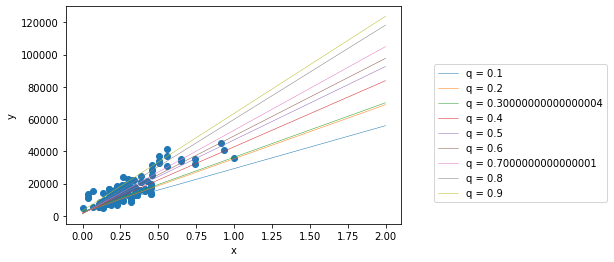

In [33]:
plt.scatter(X[7], y)
grid = np.linspace(0, 2, 100)
dat = pd.DataFrame({"x":X[7], "y":y})
mod = smf.quantreg('y ~ x', dat)
for q in np.arange(0.1, 1, 0.1):
    res = mod.fit(q=q)
    plt.plot(grid, grid * res.params["x"] + res.params["Intercept"], linewidth=0.5, label="q = "+str(q))
plt.legend(loc=(1.1, 0.1))
plt.xlabel("x")
plt.ylabel("y")